In [1]:
%load_ext autoreload
%autoreload 2

-----
# Imports and initial df 

In [2]:
import pandas as pd

from deep4deep.text_retrieval import prepare_my_df, get_meta_description_columns
from deep4deep.text_processing import text_preprocessing
from deep4deep.w2v_embedding_and_rnn_model import 

In [434]:
df = pd.read_csv('../raw_data/data2020-12-03.csv')

In [138]:
my_df = prepare_my_df(df)

---
# Importing meta-descriptions from websites and preprocessing

my_df = get_meta_description_columns(my_df)

In [437]:
#save_df = my_df.drop(columns = ['concat_text', 'preprocessed_concat_txt'])
save_df.to_csv("meta_descriptions")

---
# Embedding

In [442]:
word2vec_wiki.wv.similar_by_vector(word2vec_wiki.wv["work"])

[autoreload of deep4deep.text_retrieval failed: Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/data/envs/NLP/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/admin/.pyenv/versions/data/envs/NLP/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/admin/.pyenv/versions/3.8.5/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/admin/.pyenv/versions/3.8.5/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 783, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/admin/code/ClemenceK/deep4deep/deep4deep/text_retrieval.py", line 9, in <module>
    fr

[('work', 1.0),
 ('working', 0.9163012504577637),
 ('done', 0.8910593390464783),
 ('well', 0.8780410885810852),
 ('works', 0.8739686012268066),
 ('own', 0.8690434694290161),
 ('worked', 0.8538495898246765),
 ('besides', 0.845556914806366),
 ('making', 0.8316954970359802),
 ('doing', 0.8313522338867188)]

import ast
my_df['meta_description_preprocessed'] = my_df.meta_description_preprocessed.apply(lambda s: list(ast.literal_eval(s)))

In [144]:
# exo 3 jour 5
import gensim.downloader as api
print(list(api.info()['models'].keys()))
word2vec_wiki = api.load("glove-wiki-gigaword-50")

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [303]:
from gensim.models import Word2Vec
import csv 

#my_embedding = Word2Vec(sentences=my_df['meta_description_preprocessed'], min_count=3, window=5, size=30, sample=1e-5)


# building TSV for use in Embedding Projector

# for padding

def embed_text(preprocessed_text):
    result = []
    for word in preprocessed_text:
        if word in word2vec_wiki.wv:
            vector = word2vec_wiki.wv.get_vector(word) 
            result.append(vector)
    if len(result) == 0:
        result = [np.ones(word2vec_wiki.vector_size)*MASK_VALUE]
    return result

In [155]:
my_df.drop(columns=['meta_description_preprocessed', 'meta_description_dealroom_preprocessed', 'embedded_meta_desc'], inplace=True)

In [336]:
my_df['concat_text'] = my_df.meta_description + my_df.meta_description_dealroom
my_df['preprocessed_concat_txt'] = my_df.concat_text.map(text_preprocessing)
my_df.head(3)

,id,name,industries,url,website_url,target,meta_description,meta_description_dealroom,concat_text,preprocessed_concat_txt
0,1742681,Healthcardionexion.com,[health],https://app.dealroom.co/companies/healthcardio...,http://healthcardionexion.com,1.0,@-Health : l’apparition de la médecine prédict...,"Healthcardionexion.com, the cardionexion medic...",@-Health : l’apparition de la médecine prédict...,"[health, l, apparition, de, la, médecine, préd..."
1,1743314,4P Pharma,"[health, fintech]",https://app.dealroom.co/companies/4p_pharma,http://4p-pharma.com,1.0,4P Pharma is an R&D partner of academic and pr...,"4P Pharma, 4p-pharma | translating science to ...",4P Pharma is an R&D partner of academic and pr...,"[p, pharma, rd, partner, academic, private, in..."
2,1598607,AFYREN,[energy],https://app.dealroom.co/companies/afyren,http://afyren.com/,1.0,AFYREN offre aux industriels des molécules bio...,"AFYREN, a company specialized in microbiology ...",AFYREN offre aux industriels des molécules bio...,"[afyren, offre, aux, industriels, de, molécule..."


---
# RNN

In [383]:
my_df_categorical = my_df[my_df['target']!=0.5].copy()
#my_df_categorical.loc[my_df_categorical.target == 0.5,'target'] = 2 # dropping the 'almost_deep_tech' 
#almost=0.5
#my_df_almost_higher = my_df.copy()
#my_df_almost_higher.loc[my_df_almost_higher.target == 0.5,'target'] = almost

# vraies deeptech: labellisées

# vraies non-deeptech: fichier cosmétique (qu'on n'a pas)
# label non-deep tech? oui mais à revoir

# passer en 3 catégories


In [385]:
my_df_categorical['target'].unique() # verif
my_df_categorical.shape

(1334, 10)

In [426]:
# make X and y
X_embedded = my_df.preprocessed_concat_txt.map(embed_text)
y = my_df.target

<ipython-input-303-b3992ca8050c>:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in word2vec_wiki.wv:
<ipython-input-303-b3992ca8050c>:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vector = word2vec_wiki.wv.get_vector(word)


In [398]:
# dummy baseline (with 0.7 as almost)
dummy_prediction = my_df_categorical.target.mean()
print(f"dummy prediction: {dummy_prediction*100:.2f}%")

dummy_rmse = ((y - prediction)**2).mean()**0.5
print(f"dummy_rmse: {dummy_rmse:.2f}")
dummy_mae = (abs(y - prediction)).mean()
print(f"dummy_mae: {dummy_mae:.2f}")



dummy prediction: 48.28%
dummy_rmse: 0.50
dummy_mae: 0.50


In [427]:
#padding

from tensorflow.keras.preprocessing.sequence import pad_sequences

X_pad = pad_sequences(X_embedded, 
              dtype='float32', 
              padding='post', 
              value=MASK_VALUE)
X_pad.shape, X_pad[0].shape

((1513, 112, 50), (112, 50))

In [428]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25)

In [390]:
# what's the size of vocabulary?
vocab_size = len(word2vec_wiki.wv.vocab)
# embedded with vectors of 30
size_embedding = word2vec_wiki.vector_size

<ipython-input-390-31c8ea520676>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vocab_size = len(word2vec_wiki.wv.vocab)


In [391]:
# define early stopping

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=30, restore_best_weights=True)


In [429]:
# model

from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

model = models.Sequential()

model.add(layers.Masking(mask_value=MASK_VALUE)) 

model.add(layers.LSTM(units=12, activation='tanh', return_sequences=True)) # NEED True if and only if you add another LSTM after
model.add(layers.Dropout(rate=0.2))
model.add(layers.LSTM(units=20, activation='tanh', return_sequences=False)) # need FALSE for last LSTM layer
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Dense(1, activation='sigmoid'))

# –– Compilation
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae', 'mse', 'accuracy'])


# –– Fit
history = model.fit(X_train, y_train, epochs= 500, batch_size=32, callbacks=[es], validation_data=(X_val, y_val))


Epoch 1/500
29/29 [==============================] - 7s 252ms/step - loss: 0.2582 - mae: 0.4473 - mse: 0.2582 - accuracy: 0.4752 - val_loss: 0.1885 - val_mae: 0.3982 - val_mse: 0.1885 - val_accuracy: 0.5314
Epoch 2/500
29/29 [==============================] - 4s 144ms/step - loss: 0.2212 - mae: 0.4122 - mse: 0.2212 - accuracy: 0.5369 - val_loss: 0.1662 - val_mae: 0.3696 - val_mse: 0.1662 - val_accuracy: 0.6370
Epoch 3/500
29/29 [==============================] - 5s 156ms/step - loss: 0.1990 - mae: 0.3884 - mse: 0.1990 - accuracy: 0.5755 - val_loss: 0.1616 - val_mae: 0.3469 - val_mse: 0.1616 - val_accuracy: 0.6337
Epoch 4/500
29/29 [==============================] - 4s 148ms/step - loss: 0.1919 - mae: 0.3740 - mse: 0.1919 - accuracy: 0.6108 - val_loss: 0.1603 - val_mae: 0.3506 - val_mse: 0.1603 - val_accuracy: 0.6436
Epoch 5/500
29/29 [==============================] - 4s 148ms/step - loss: 0.1905 - mae: 0.3741 - mse: 0.1905 - accuracy: 0.6009 - val_loss: 0.1609 - val_mae: 0.3484 - val_

In [430]:
for i in range(3):
    print(f"prediction: {model.predict(X_val[[i]])[0]}, real: {y_val.iloc[i]}")

prediction: [0.23923987], real: 0.0
prediction: [1.0085276], real: 0.5
prediction: [0.52062714], real: 0.0


In [431]:
y_pred = model.predict(X_val)
model_rmse = ((y_val - y_pred[:,0])**2).mean()**0.5
print(f"model_rmse: {model_rmse:.2f}, vs original_rmse: {.4325:.2f}() and dummy_rmse:{dummy_rmse:.2f} ")

model_rmse: 0.39, vs original_rmse: 0.43() and dummy_rmse:0.50 


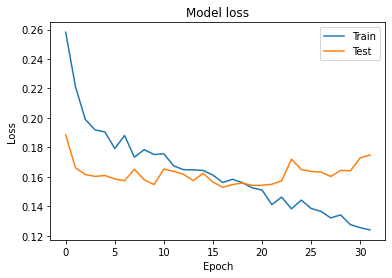

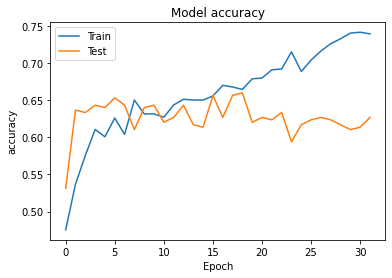

In [433]:
import matplotlib.pyplot as plt

def plot_loss_mae(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    
plot_loss_mae(history)


In [332]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_22 (Masking)         (None, 95, 50)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 10)                2440      
_________________________________________________________________
dense_49 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 11        
Total params: 2,671
Trainable params: 2,671
Non-trainable params: 0
___________________________________________________

In [443]:
%whos

Variable                       Type                    Data/Info
----------------------------------------------------------------
EarlyStopping                  type                    <class 'tensorflow.python<...>callbacks.EarlyStopping'>
MASK_VALUE                     int                     -100
Word2Vec                       type                    <class 'gensim.models.word2vec.Word2Vec'>
X                              Series                  0       [healthcardionexi<...>ngth: 1513, dtype: object
X_embedded                     Series                  0       [[0.31161, 0.3390<...>ngth: 1513, dtype: object
X_embedded_cropped             Series                  0       [[-0.0045175664, <...>ngth: 1513, dtype: object
X_pad                          ndarray                 1513x112x50: 8472800 elems, type `float32`, 33891200 bytes (32.3211669921875 Mb)
X_test                         ndarray                 303x112x50: 1696800 elems, type `float32`, 6787200 bytes (6.4727783203125 Mb)


In [444]:
my_df

,id,name,industries,url,website_url,target,meta_description,meta_description_dealroom,concat_text,preprocessed_concat_txt
0,1742681,Healthcardionexion.com,[health],https://app.dealroom.co/companies/healthcardio...,http://healthcardionexion.com,1.0,@-Health : l’apparition de la médecine prédict...,"Healthcardionexion.com, the cardionexion medic...",@-Health : l’apparition de la médecine prédict...,"[health, l, apparition, de, la, médecine, préd..."
1,1743314,4P Pharma,"[health, fintech]",https://app.dealroom.co/companies/4p_pharma,http://4p-pharma.com,1.0,4P Pharma is an R&D partner of academic and pr...,"4P Pharma, 4p-pharma | translating science to ...",4P Pharma is an R&D partner of academic and pr...,"[p, pharma, rd, partner, academic, private, in..."
2,1598607,AFYREN,[energy],https://app.dealroom.co/companies/afyren,http://afyren.com/,1.0,AFYREN offre aux industriels des molécules bio...,"AFYREN, a company specialized in microbiology ...",AFYREN offre aux industriels des molécules bio...,"[afyren, offre, aux, industriels, de, molécule..."
3,894817,Abbelight,[health],https://app.dealroom.co/companies/abbelight,http://www.abbelight.com,1.0,"Abbelight provides hardware solutions, softwar...","Abbelight, innovative solutions in the field o...","Abbelight provides hardware solutions, softwar...","[abbelight, provides, hardware, solution, soft..."
4,1683057,AblaCare,[health],https://app.dealroom.co/companies/ablacare,https://ablacare.com,1.0,Ablacare,"AblaCare, ablacare is a medical device company...","AblacareAblaCare, ablacare is a medical device...","[ablacareablacare, ablacare, medical, device, ..."
...,...,...,...,...,...,...,...,...,...,...
1508,1660577,Opta LP,[home living],https://app.dealroom.co/companies/opta_lp,http://opta-lp.com,0.5,"Opta LP, opta lp | optimization softwares to i...","Opta LP, opta lp | optimization softwares to i...","Opta LP, opta lp | optimization softwares to i...","[opta, lp, opta, lp, optimization, software, i..."
1509,132854,Ownpage Technology,[enterprise software],https://app.dealroom.co/companies/ownpage_tech...,http://www.ownpage.fr/,0.5,Augmentez vos revenus éditoriaux avec les solu...,"Ownpage Technology, helps publishers to person...",Augmentez vos revenus éditoriaux avec les solu...,"[augmentez, vos, revenus, éditoriaux, avec, le..."
1510,80695,Per Angusta,[enterprise software],https://app.dealroom.co/companies/per_angusta,https://per-angusta.com,0.5,Per Angusta is a SaaS Procurement Performance ...,"Per Angusta, helps cpos manage their sourcing ...",Per Angusta is a SaaS Procurement Performance ...,"[per, angusta, saas, procurement, performance,..."
1511,1836415,PowerUp,[energy],https://app.dealroom.co/companies/powerup_1,http://powerup.xyz,0.5,"PowerUp, . Here you'll find information about ...","PowerUp, . Here you'll find information about ...","PowerUp, . Here you'll find information about ...","[powerup, youll, find, information, funding, i..."


In [447]:
X_recu=my_df.head(5)

In [448]:
X_recu

,id,name,industries,url,website_url,target,meta_description,meta_description_dealroom,concat_text,preprocessed_concat_txt
0,1742681,Healthcardionexion.com,[health],https://app.dealroom.co/companies/healthcardio...,http://healthcardionexion.com,1.0,@-Health : l’apparition de la médecine prédict...,"Healthcardionexion.com, the cardionexion medic...",@-Health : l’apparition de la médecine prédict...,"[health, l, apparition, de, la, médecine, préd..."
1,1743314,4P Pharma,"[health, fintech]",https://app.dealroom.co/companies/4p_pharma,http://4p-pharma.com,1.0,4P Pharma is an R&D partner of academic and pr...,"4P Pharma, 4p-pharma | translating science to ...",4P Pharma is an R&D partner of academic and pr...,"[p, pharma, rd, partner, academic, private, in..."
2,1598607,AFYREN,[energy],https://app.dealroom.co/companies/afyren,http://afyren.com/,1.0,AFYREN offre aux industriels des molécules bio...,"AFYREN, a company specialized in microbiology ...",AFYREN offre aux industriels des molécules bio...,"[afyren, offre, aux, industriels, de, molécule..."
3,894817,Abbelight,[health],https://app.dealroom.co/companies/abbelight,http://www.abbelight.com,1.0,"Abbelight provides hardware solutions, softwar...","Abbelight, innovative solutions in the field o...","Abbelight provides hardware solutions, softwar...","[abbelight, provides, hardware, solution, soft..."
4,1683057,AblaCare,[health],https://app.dealroom.co/companies/ablacare,https://ablacare.com,1.0,Ablacare,"AblaCare, ablacare is a medical device company...","AblacareAblaCare, ablacare is a medical device...","[ablacareablacare, ablacare, medical, device, ..."


In [471]:
my_df_meta = pd.read_csv("../raw_data/my_df_with_metatags.csv")